In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [2]:
from codebase import volume_pipeline

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [4]:
res_ref = codebase.load_data.load_formatted_usbr_data('mead')
res_ref_M = res_ref.resample('M').mean()

In [5]:
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('hoover',res_shp,epsg_code=54017)
# dem_DA_flat = volume_pipeline.project_DA_from_crs_code(dem_DA,54017)
# fw_DA_flat = volume_pipeline.project_DA_from_crs_code(fw_DA,54017)

In [7]:
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['y','x'])
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

In [12]:
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA)
change_cond_DA_kwargs = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA, input_core_dims = ['lon','lat'])
change_cond_DA_flat = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA_flat, input_core_dims = ['y','x'])

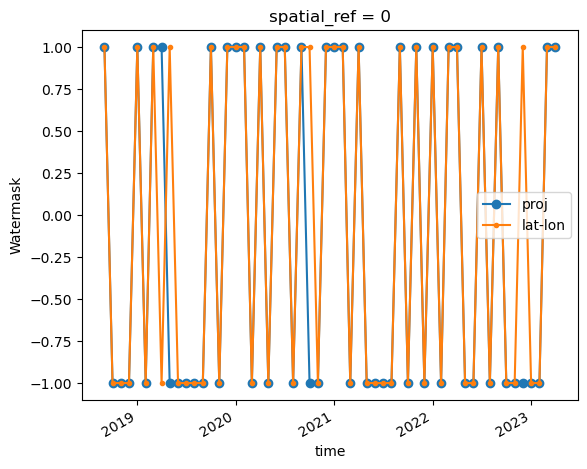

In [25]:
change_cond_DA_flat.plot(marker='o')
change_cond_DA_kwargs.plot(marker='.')
plt.legend(['proj','lat-lon'])

In [37]:
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA)
test_vol_kwargs = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA,
                                                         area_kwargs = {'input_core_dims' : [['lat','lon']], "vectorize": True})

In [49]:
test_vol_flat = volume_pipeline.calculate_rough_volume(dem_DA_flat,fw_DA_flat,fw_diff_DA_flat,change_cond_DA_flat,area_kwargs = {'input_core_dims' : [['y','x']], "vectorize": True})

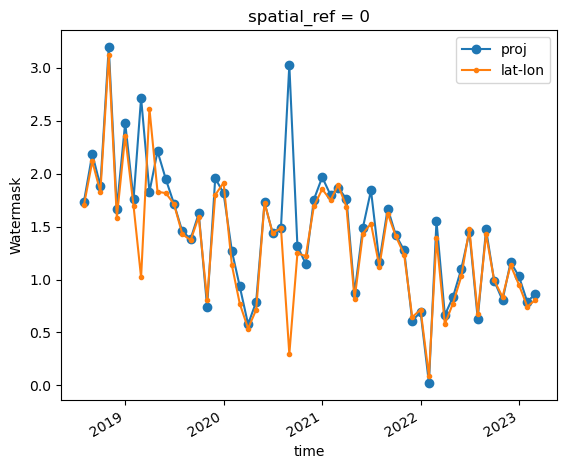

In [54]:
test_vol_flat.plot(marker='o')
test_vol_kwargs.plot(marker='.')
plt.legend(['proj','lat-lon'])

<Axes: >

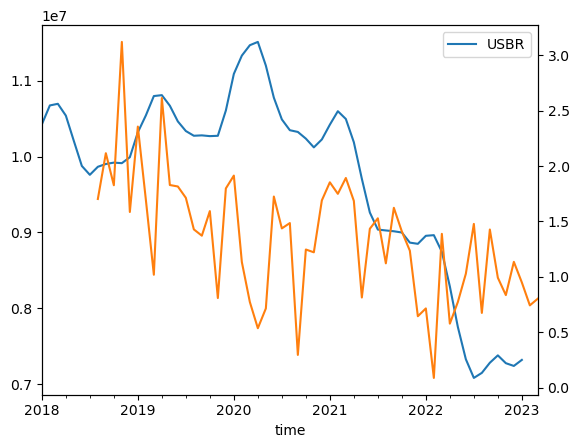

In [55]:
res_ref_M.plot(y='Lake/Reservoir Storage [af]', label='USBR')
test_vol.to_dataframe()['Watermask'].plot(label='Experimental',secondary_y= True)

In [ ]:
fw_diff_DA.isel(time=1).plot(cmap='RdBu')